In [1]:
import numpyro

import pandas as pd
import numpy as np

import arviz as az

import matplotlib.pyplot as plt
import data_gen as dg
import models as pr

import jax

In [2]:
import sys
sys.version

'3.12.4 (v3.12.4:8e8a4baf65, Jun  6 2024, 17:33:18) [Clang 13.0.0 (clang-1300.0.29.30)]'

In [3]:
print(numpyro.__version__)
print(pd.__version__)
print(az.__version__)
print(np.__version__)
print(jax.__version__)

0.15.0
2.2.2
0.18.0
1.26.4
0.4.28


# Data prep

In [4]:
dims = 20

In [5]:
data = dg.gen_data(N=2000, K=5, D=dims, R=6, prob_cutoff=0.1, seed=16)
disc_data = data["dataframe"].loc[:, [k for k in data["dataframe"].keys() if k.startswith("disc_var_")]]
r_data = data["dataframe"].loc[:, [k for k in data["dataframe"].keys() if k.startswith("r_var_")]]

In [6]:
np.sum([len(i) for i in data["cluster_features"]])

18

In [7]:
sorted(data["coefficients"])

[array([-0.30678851]),
 array([0.81607932]),
 array([1.04824511]),
 array([1.27929641]),
 array([1.63034001]),
 array([1.89282058])]

In [8]:
sorted(data["intercepts"])

[-1.5983909222837998,
 -1.2939183481571335,
 -0.4605678005144168,
 0.3395370644387464,
 1.0151544453813026]

# MCMC Gibbs sampling

In [9]:
import importlib
importlib.reload(pr)

<module 'models' from '/Users/jim/Library/CloudStorage/OneDrive-SwanseaUniversity/home/code/profile_regression/profile_regression_numpyro/models.py'>

In [10]:
%%time 

az_obj_mcmc = pr.fit_profile_regression_model_MCMC(
    disc_data.to_numpy(),
    r_data.to_numpy(),
    data["dataframe"]["outcome"].to_numpy(),
    10,
    500,
    1000,
    alpha=None
)

CPU times: user 58min 53s, sys: 27.7 s, total: 59min 21s
Wall time: 59min 21s


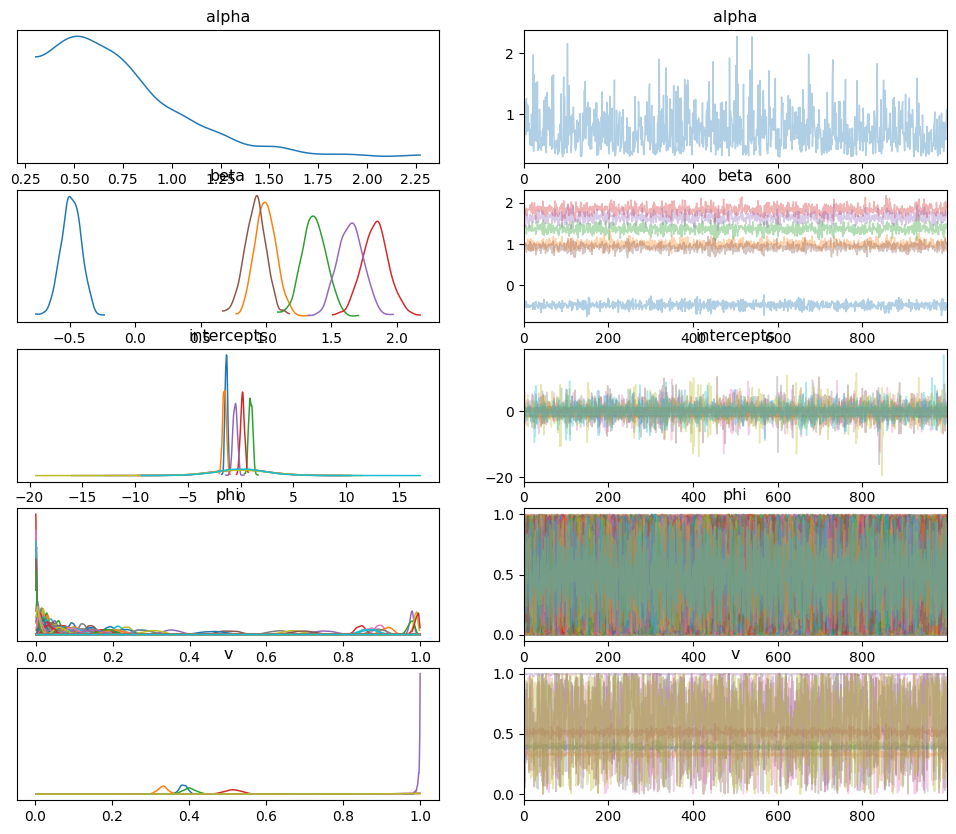

In [11]:
fig = az.plot_trace(az_obj_mcmc)

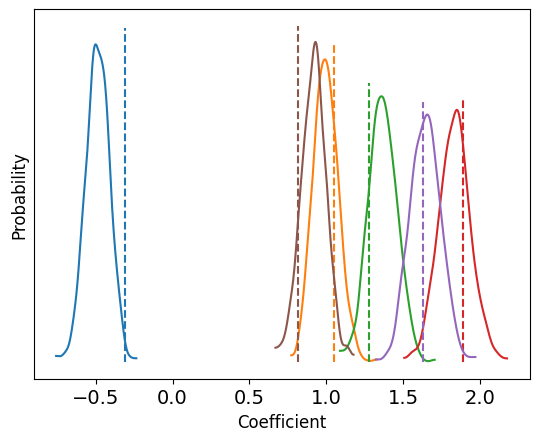

In [29]:
plt.figure()
for i in range(az_obj_mcmc.posterior["beta_dim_0"].shape[0]):
    fig = az.plot_dist(
        az_obj_mcmc.posterior.sel(beta_dim_0=i)["beta"], color="C{}".format(i)
    )
    
    plt.vlines(data["coefficients"][i], 0, 1.05 * fig.lines[i].get_ydata().max(), color="C{}".format(i), linestyle="dashed")

plt.yticks([])
plt.xlabel("Coefficient", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("MCMC_coef_posterior.png", dpi=300)
plt.show()

<timed exec>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


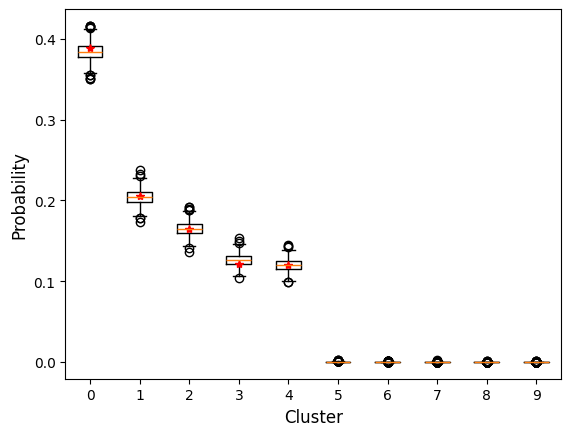

CPU times: user 971 ms, sys: 9.27 ms, total: 980 ms
Wall time: 385 ms


In [30]:
%%time

v_samples = az_obj_mcmc["posterior"]["v"].to_numpy().squeeze()

weight_mat = np.zeros((v_samples.shape[0], v_samples.shape[-1] + 1))

for i in range(v_samples.shape[0]):
    weight_mat[i, :] = pr.mix_weights(v_samples[i, :])  
    
inds = np.argsort(np.median(weight_mat, axis=0))[::-1]
    
plt.figure()
bp1 = plt.boxplot(weight_mat[:, inds], labels=range(weight_mat.shape[-1]))
plt.plot(range(1, len(data["cluster_probs"]) + 1), sorted(data["cluster_probs"])[::-1], "r*")
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Probability",fontsize=12)
plt.savefig("MCMC_Gibbs_cluster_probs.png", dpi=300)
plt.show()

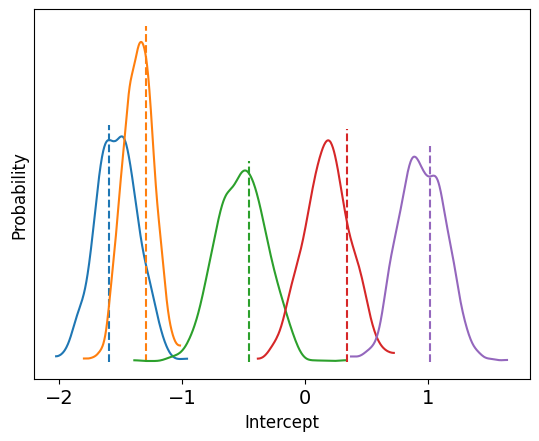

In [31]:
cluster_inds = np.argsort(np.median(weight_mat, axis=0))[::-1][0:5]
coef_inds = []
for i in cluster_inds:
    coef_inds.append([np.mean(az_obj_mcmc.posterior.sel(intercepts_dim_0=i)["intercepts"].to_numpy()), i])

intercept_inds = np.array(sorted(coef_inds), dtype=int)[:, 1]
    
plt.figure()
for cnt, i in enumerate(intercept_inds):
    fig = az.plot_dist(
        az_obj_mcmc.posterior.sel(intercepts_dim_0=i)["intercepts"], color="C{}".format(cnt)
    )    
    plt.vlines(sorted(data["intercepts"])[cnt], 0, 1.05 * fig.lines[cnt].get_ydata().max(), color="C{}".format(cnt), linestyle="dashed")

plt.yticks([])
plt.xlabel("Intercept", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("MCMC_intercept_posterior.png", dpi=300)
plt.show()

# New SVI

In [15]:
import importlib
importlib.reload(pr)

<module 'models' from '/Users/jim/Library/CloudStorage/OneDrive-SwanseaUniversity/home/code/profile_regression/profile_regression_numpyro/models.py'>

In [16]:
%%time

az_obj, loss = pr.fit_profile_regression_model(
    disc_data.to_numpy(),
    r_data.to_numpy(),
    data["dataframe"]["outcome"].to_numpy(),
    10,
    5000,
    1000,
    alpha=None
)

jax.profiler.save_device_memory_profile("no_posterior_predictive.prof")


CPU times: user 8.87 s, sys: 710 ms, total: 9.58 s
Wall time: 6.61 s


In [17]:
%%time

az_obj, loss = pr.fit_profile_regression_model(
    disc_data.to_numpy(),
    r_data.to_numpy(),
    data["dataframe"]["outcome"].to_numpy(),
    10,
    5000,
    1000,
    alpha=None,
    posterior_predictive=True
)

jax.profiler.save_device_memory_profile("with_posterior_predictive.prof")

CPU times: user 9.99 s, sys: 947 ms, total: 10.9 s
Wall time: 7.55 s


In [18]:
pd.set_option('display.max_rows', None)
fit = az.summary(az_obj)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [19]:
fit.loc[fit.index.str.startswith("v"), :] 

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v[0]  0.124  0.008   0.109    0.139        0.0      0.0     913.0     792.0   
v[1]  0.005  0.002   0.002    0.009        0.0      0.0     962.0     822.0   
v[2]  0.002  0.001   0.000    0.004        0.0      0.0     765.0     944.0   
v[3]  0.001  0.001   0.000    0.002        0.0      0.0     960.0    1023.0   
v[4]  0.001  0.001   0.000    0.002        0.0      0.0     917.0     833.0   
v[5]  0.189  0.009   0.170    0.204        0.0      0.0     923.0     915.0   
v[6]  0.169  0.010   0.148    0.186        0.0      0.0    1051.0     948.0   
v[7]  0.650  0.013   0.626    0.674        0.0      0.0     938.0     983.0   
v[8]  0.003  0.003   0.000    0.007        0.0      0.0    1063.0     996.0   

      r_hat  
v[0]    NaN  
v[1]    NaN  
v[2]    NaN  
v[3]    NaN  
v[4]    NaN  
v[5]    NaN  
v[6]    NaN  
v[7]    NaN  
v[8]    NaN

<timed exec>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


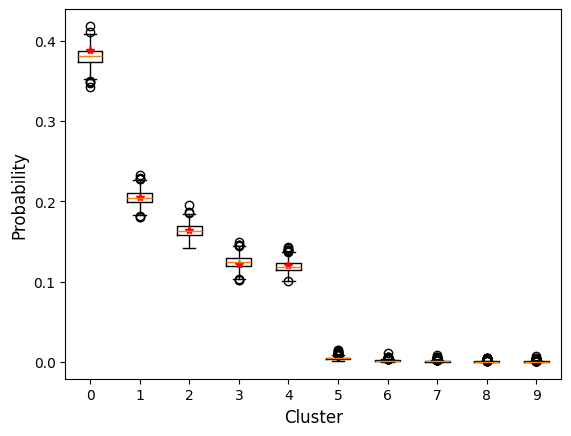

CPU times: user 692 ms, sys: 7.46 ms, total: 699 ms
Wall time: 285 ms


In [32]:
%%time

v_samples = az_obj["posterior"]["v"].to_numpy().squeeze()

weight_mat = np.zeros((v_samples.shape[0], v_samples.shape[-1] + 1))

for i in range(v_samples.shape[0]):
    weight_mat[i, :] = pr.mix_weights(v_samples[i, :])
    
    
inds = np.argsort(np.median(weight_mat, axis=0))[::-1]
    
plt.figure()
bp1 = plt.boxplot(weight_mat[:, inds], labels=range(weight_mat.shape[-1]))
plt.plot(range(1, len(data["cluster_probs"]) + 1), sorted(data["cluster_probs"])[::-1], "r*")
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("SVI_cluster_probs.png", dpi=300)
plt.show()

In [15]:
data["cluster_probs"]

array([0.12182595, 0.20521547, 0.16425305, 0.12006788, 0.38863766])

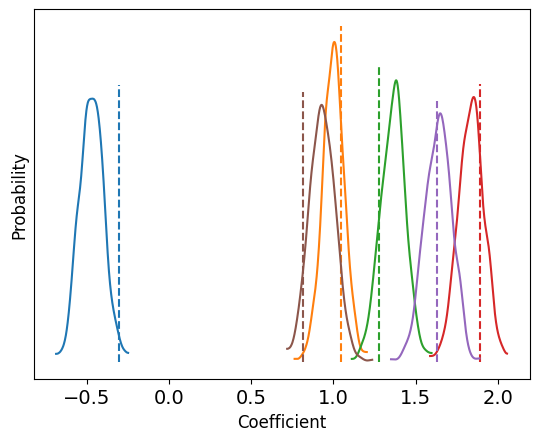

In [21]:
plt.figure()
for i in range(az_obj.posterior["beta_dim_0"].shape[0]):
    fig = az.plot_dist(
        az_obj.posterior.sel(beta_dim_0=i)["beta"], color="C{}".format(i)
    )
    
    plt.vlines(data["coefficients"][i], 0, 1.05 * fig.lines[i].get_ydata().max(), color="C{}".format(i), linestyle="dashed")

plt.yticks([])
plt.xlabel("Coefficient", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("SVI_coef_posterior.png", dpi=300)
plt.show()

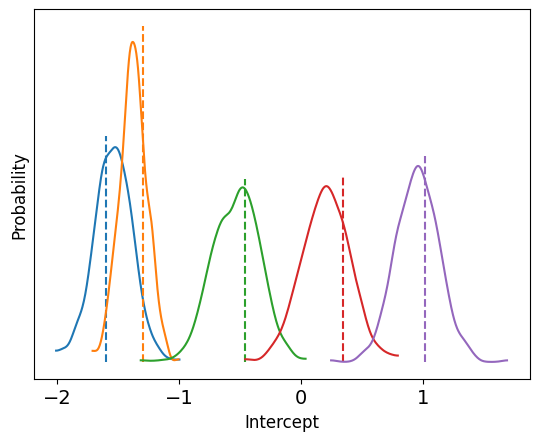

In [22]:
cluster_inds = np.argsort(np.median(weight_mat, axis=0))[::-1][0:5]
coef_inds = []
for i in cluster_inds:
    coef_inds.append([np.mean(az_obj.posterior.sel(intercepts_dim_0=i)["intercepts"].to_numpy()), i])

intercept_inds = np.array(sorted(coef_inds), dtype=int)[:, 1]
    
plt.figure()
for cnt, i in enumerate(intercept_inds):
    fig = az.plot_dist(
        az_obj.posterior.sel(intercepts_dim_0=i)["intercepts"], color="C{}".format(cnt)
    )    
    plt.vlines(sorted(data["intercepts"])[cnt], 0, 1.05 * fig.lines[cnt].get_ydata().max(), color="C{}".format(cnt), linestyle="dashed")

plt.yticks([])
plt.xlabel("Intercept", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("SVI_intercept_posterior.png", dpi=300)
plt.show()

In [23]:
z = weight_mat.mean(axis=0) - 1.96 * weight_mat.std(axis=0)
inds = np.where(z > 0)[0]

if len(inds) > 5:
    inds = inds[np.argsort(z[inds])][::-1][0:5]

index_map = {}

for j in inds:
    res = []
    for i in range(5):
        res.append(((fit.loc[fit.index.str.startswith("phi[{},".format(j)), "mean"] - data["phi"].to_numpy()[:, i]).to_numpy() ** 2).mean())
    index_map[j] = np.argmin(res)

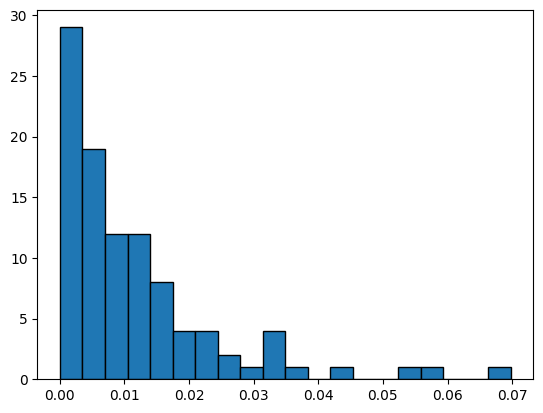

In [24]:
plt.figure()
plt.hist(
    (np.array([(fit.loc[fit.index.str.startswith("phi[{},".format(k)), "mean"] - data["phi"].to_numpy()[:, index_map[k]]).to_numpy() for k in index_map]).reshape(-1) ** 2) ** 0.5,
    edgecolor="k",
    bins=20
)
plt.show()

In [25]:
print("Intercepts")
print("Fit value\tTrue value")
for k in index_map:
    print(fit.loc[fit.index.str.startswith("intercepts[{}".format(k)), "mean"].to_numpy()[0], "\t\t", data["intercepts"][index_map[k]].round(4))

Intercepts
Fit value	True value
-1.375 		 -1.5984
-1.541 		 -1.2939
0.95 		 1.0152
0.201 		 0.3395
-0.533 		 -0.4606


In [26]:
print("Cluster probabilities")
print("Fit value\tTrue value")
for k in index_map:
    print(weight_mat[:, k].mean().round(4), "\t\t", data["cluster_probs"][index_map[k]].round(4))

Cluster probabilities
Fit value	True value
0.3803 		 0.3886
0.2044 		 0.2052
0.1637 		 0.1643
0.1242 		 0.1218
0.1191 		 0.1201


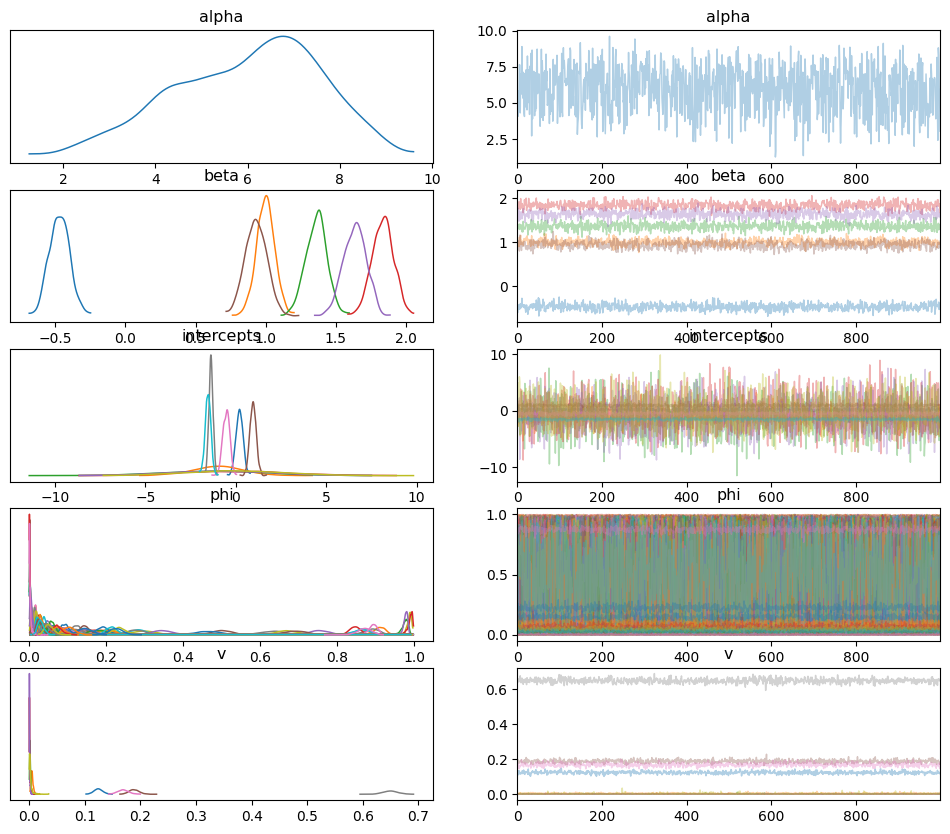

In [27]:
fig = az.plot_trace(az_obj)

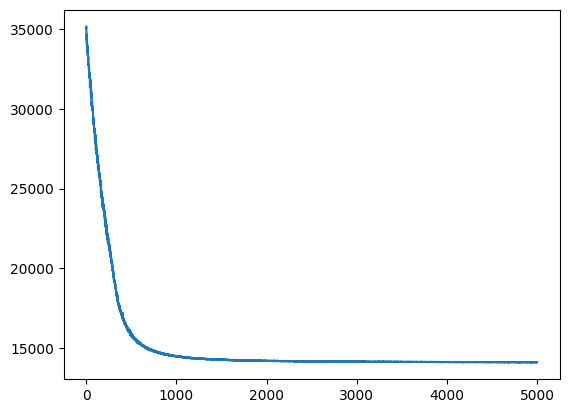

In [28]:
plt.figure()
plt.plot(loss)
plt.show()

In [18]:
importlib.reload(pr)

<module 'models' from '/Users/jim/Library/CloudStorage/OneDrive-SwanseaUniversity/home/code/profile_regression/profile_regression_numpyro/models.py'>

In [19]:
pr.k_fold_ELPD_profile_regression(
    disc_data.to_numpy(),
    r_data.to_numpy(),
    data["dataframe"]["outcome"].to_numpy(),
    10, 
    5000,
    1000,
    folds=10,
    parallel=3,
    verbose=True,
    alpha=None
)

  0%|                                                                                                                                        | 0/10 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


ELPD summary:
-------------
Main term: -13779.899414
Bias correction: -2.615758
Folds: 10


-13782.516

# Model fit with uninformative parameters

In [33]:
import importlib
importlib.reload(pr)

<module 'models' from '/Users/jim/Library/CloudStorage/OneDrive-SwanseaUniversity/home/code/profile_regression/profile_regression_numpyro/models.py'>

In [34]:
max_features = 200
informative_dim_target = 12
clusters = 5

data = dg.gen_data(N=2000, K=clusters, D=max_features, R=6, n_features_factor=informative_dim_target/max_features, prob_cutoff=0.1, seed=95)

features = np.concatenate(data["cluster_features"])
disc_data = data["dataframe"].loc[:, [k for k in data["dataframe"].keys() if k.startswith("disc_var_")]].to_numpy()
r_data = data["dataframe"].loc[:, [k for k in data["dataframe"].keys() if k.startswith("r_var_")]].to_numpy()

uninf_features = [i for i in range(disc_data.shape[-1]) if i not in features]

rng = np.random.Generator(np.random.PCG64())
rng.bit_generator.state = np.random.PCG64(95).state
rng.shuffle(uninf_features)

In [35]:
print(sum([len(i) for i in data["cluster_features"]]))

14


## Extreme plots

In [36]:
az_obj_uninf_0, loss = pr.fit_profile_regression_model(
    disc_data[:, features],
    r_data,
    data["dataframe"]["outcome"].to_numpy(),
    10,
    5000,
    1000,
    alpha=None
)

<timed exec>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


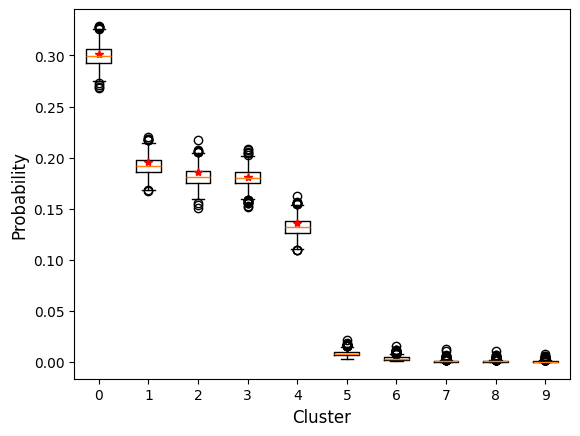

CPU times: user 929 ms, sys: 9.62 ms, total: 939 ms
Wall time: 759 ms


In [37]:
%%time

v_samples = az_obj_uninf_0["posterior"]["v"].to_numpy().squeeze()

weight_mat = np.zeros((v_samples.shape[0], v_samples.shape[-1] + 1))

for i in range(v_samples.shape[0]):
    weight_mat[i, :] = pr.mix_weights(v_samples[i, :])
    
    
inds = np.argsort(np.median(weight_mat, axis=0))[::-1]
    
plt.figure()
bp1 = plt.boxplot(weight_mat[:, inds], labels=range(weight_mat.shape[-1]))
plt.plot(range(1, len(data["cluster_probs"]) + 1), sorted(data["cluster_probs"])[::-1], "r*")
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("uninf_0_cluster_probs.png", dpi=300)
plt.show()

In [38]:
%%time
az_obj_uninf_10, loss = pr.fit_profile_regression_model(
    disc_data[:, np.concatenate((features, uninf_features[0:10]))],
    r_data,
    data["dataframe"]["outcome"].to_numpy(),
    10,
    5000,
    1000,
    alpha=None
)

CPU times: user 8.73 s, sys: 683 ms, total: 9.42 s
Wall time: 6.97 s


<timed exec>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


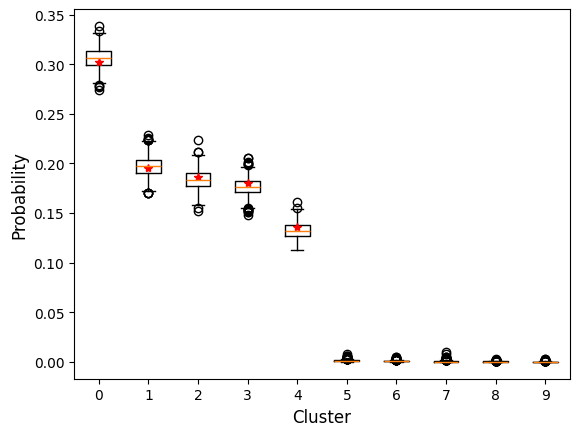

CPU times: user 941 ms, sys: 7.25 ms, total: 948 ms
Wall time: 2.43 s


In [39]:
%%time

v_samples = az_obj_uninf_10["posterior"]["v"].to_numpy().squeeze()

weight_mat = np.zeros((v_samples.shape[0], v_samples.shape[-1] + 1))

for i in range(v_samples.shape[0]):
    weight_mat[i, :] = pr.mix_weights(v_samples[i, :])
    
    
inds = np.argsort(np.median(weight_mat, axis=0))[::-1]
    
plt.figure()
bp1 = plt.boxplot(weight_mat[:, inds], labels=range(weight_mat.shape[-1]))
plt.plot(range(1, len(data["cluster_probs"]) + 1), sorted(data["cluster_probs"])[::-1], "r*")
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("uninf_10_cluster_probs.png", dpi=300)
plt.show()

In [40]:
%%time
az_obj_uninf_20, loss = pr.fit_profile_regression_model(
    disc_data[:, np.concatenate((features, uninf_features[0:20]))],
    r_data,
    data["dataframe"]["outcome"].to_numpy(),
    10,
    5000,
    1000,
    alpha=None
)

CPU times: user 13.5 s, sys: 718 ms, total: 14.2 s
Wall time: 11.6 s


<timed exec>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


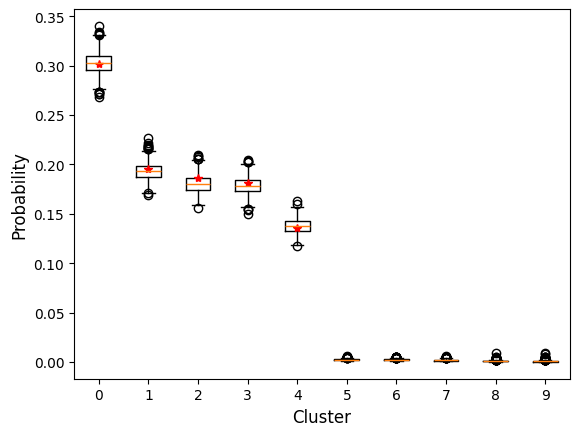

CPU times: user 872 ms, sys: 8.49 ms, total: 881 ms
Wall time: 497 ms


In [41]:
%%time

v_samples = az_obj_uninf_20["posterior"]["v"].to_numpy().squeeze()

weight_mat = np.zeros((v_samples.shape[0], v_samples.shape[-1] + 1))

for i in range(v_samples.shape[0]):
    weight_mat[i, :] = pr.mix_weights(v_samples[i, :])
    
    
inds = np.argsort(np.median(weight_mat, axis=0))[::-1]
    
plt.figure()
bp1 = plt.boxplot(weight_mat[:, inds], labels=range(weight_mat.shape[-1]))
plt.plot(range(1, len(data["cluster_probs"]) + 1), sorted(data["cluster_probs"])[::-1], "r*")
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("uninf_20_cluster_probs.png", dpi=300)
plt.show()

In [45]:
%%time
az_obj_uninf_30, loss = pr.fit_profile_regression_model(
    disc_data[:, np.concatenate((features, uninf_features[0:30]))],
    r_data,
    data["dataframe"]["outcome"].to_numpy(),
    10,
    5000,
    1000,
    alpha=None
)

CPU times: user 16.6 s, sys: 779 ms, total: 17.4 s
Wall time: 13.5 s


<timed exec>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


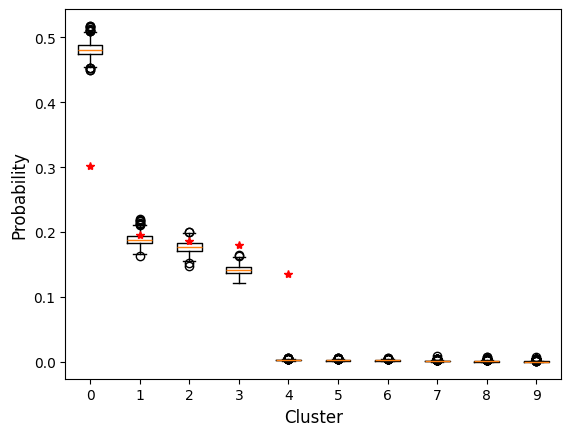

CPU times: user 1.03 s, sys: 8.68 ms, total: 1.04 s
Wall time: 741 ms


In [46]:
%%time

v_samples = az_obj_uninf_30["posterior"]["v"].to_numpy().squeeze()

weight_mat = np.zeros((v_samples.shape[0], v_samples.shape[-1] + 1))

for i in range(v_samples.shape[0]):
    weight_mat[i, :] = pr.mix_weights(v_samples[i, :])
    
    
inds = np.argsort(np.median(weight_mat, axis=0))[::-1]
    
plt.figure()
bp1 = plt.boxplot(weight_mat[:, inds], labels=range(weight_mat.shape[-1]))
plt.plot(range(1, len(data["cluster_probs"]) + 1), sorted(data["cluster_probs"])[::-1], "r*")
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("uninf_30_cluster_probs.png", dpi=300)
plt.show()

In [23]:
elpd_list = []
n_uninf_feat_list = []
feat_offset = len(features)
n_added_features = 5
n_runs = 7

for _ in range(n_runs):
    
    elpd_10_fold = pr.k_fold_ELPD_profile_regression(
        disc_data[:, features],
        r_data,
        data["dataframe"]["outcome"].to_numpy(),
        10, 
        5000,
        1000,
        folds=10,
        parallel=3,
        verbose=False,
        alpha=None
    )
    
    elpd_list.append(elpd_10_fold)
    n_uninf_feat_list.append(len(features) - feat_offset)
    
    for _ in range(n_added_features):
        features = np.append(features, uninf_features.pop())


 60%|████████████████████████                | 6/10 [00:34<00:22,  5.72s/it]C:\Users\j.m.rafferty\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|███████████████████████████████████████| 10/10 [01:12<00:00,  7.28s/it]


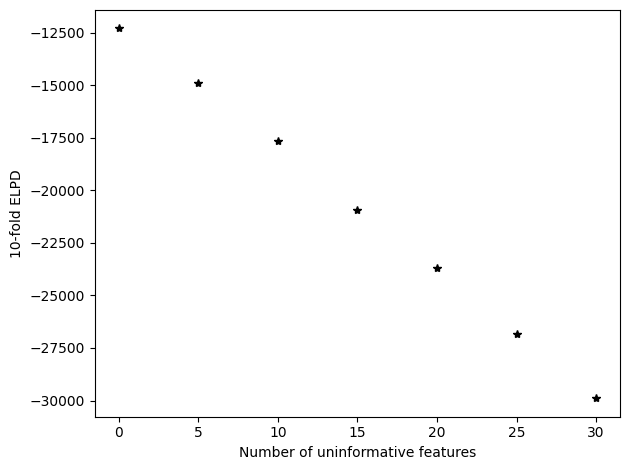

In [24]:
plt.figure()
plt.plot(n_uninf_feat_list, elpd_list, "k*")
plt.xlabel("Number of uninformative features")
plt.ylabel("10-fold ELPD")
plt.tight_layout()
plt.savefig("uniformative_features_ELPD.png", dpi=300)
plt.show()

# "No clusters"

## Cluster with no high probability discrete features and no events

In [47]:
importlib.reload(dg)

<module 'data_gen' from '/Users/jim/Library/CloudStorage/OneDrive-SwanseaUniversity/home/code/profile_regression/profile_regression_numpyro/data_gen.py'>

In [48]:
data = dg.gen_data(
    N=2000, 
    K=5,
    D=20,
    R=6,
    n_features_factor=1.0,
    prob_cutoff=0.1,
    empty_cluster=True,
    seed=451
)

In [49]:
data["dataframe"].groupby(by="cluster_label").sum()["outcome"]

cluster_label
0.0    269.0
1.0     85.0
2.0    252.0
3.0    175.0
4.0      0.0
Name: outcome, dtype: float64

In [50]:
disc_data = data["dataframe"].loc[:, [k for k in data["dataframe"].keys() if k.startswith("disc_var_")]].to_numpy()
r_data = data["dataframe"].loc[:, [k for k in data["dataframe"].keys() if k.startswith("r_var_")]].to_numpy()

az_obj, loss = pr.fit_profile_regression_model(
    disc_data,
    r_data,
    data["dataframe"]["outcome"].to_numpy(),
    10,
    5000,
    1000,
    alpha=None
)

<timed exec>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


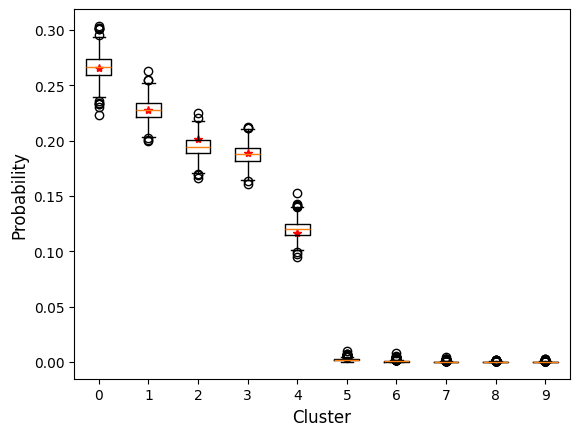

CPU times: user 882 ms, sys: 10.9 ms, total: 893 ms
Wall time: 662 ms


In [51]:
%%time

v_samples = az_obj["posterior"]["v"].to_numpy().squeeze()

weight_mat = np.zeros((v_samples.shape[0], v_samples.shape[-1] + 1))
for i in range(v_samples.shape[0]):
    weight_mat[i, :] = pr.mix_weights(v_samples[i, :])

inds = np.argsort(np.median(weight_mat, axis=0))[::-1]
    
plt.figure()
plt.plot(range(1, len(data["cluster_probs"]) + 1), sorted(data["cluster_probs"])[::-1], "r*")
plt.boxplot(weight_mat[:, inds], labels=range(weight_mat.shape[-1]))
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("no_cluster_probs.png", dpi=300)
plt.show()

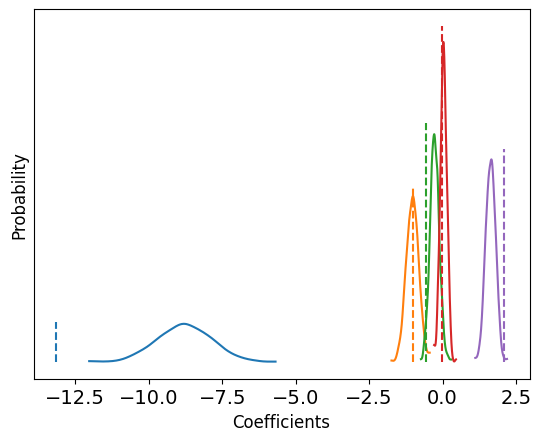

In [52]:
cluster_inds = np.argsort(np.median(weight_mat, axis=0))[::-1][0:5]
coef_inds = []
for i in cluster_inds:
    coef_inds.append([np.mean(az_obj.posterior.sel(intercepts_dim_0=i)["intercepts"].to_numpy()), i])

intercept_inds = np.array(sorted(coef_inds), dtype=int)[:, 1]
    
plt.figure()
for cnt, i in enumerate(intercept_inds):
    fig = az.plot_dist(
        az_obj.posterior.sel(intercepts_dim_0=i)["intercepts"], color="C{}".format(cnt)
    )    
    plt.vlines(sorted(data["intercepts"])[cnt], 0, 1.05 * fig.lines[cnt].get_ydata().max(), color="C{}".format(cnt), linestyle="dashed")

plt.yticks([])
plt.xlabel("Coefficients", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("no_cluster_coefs.png", dpi=300)
plt.show()

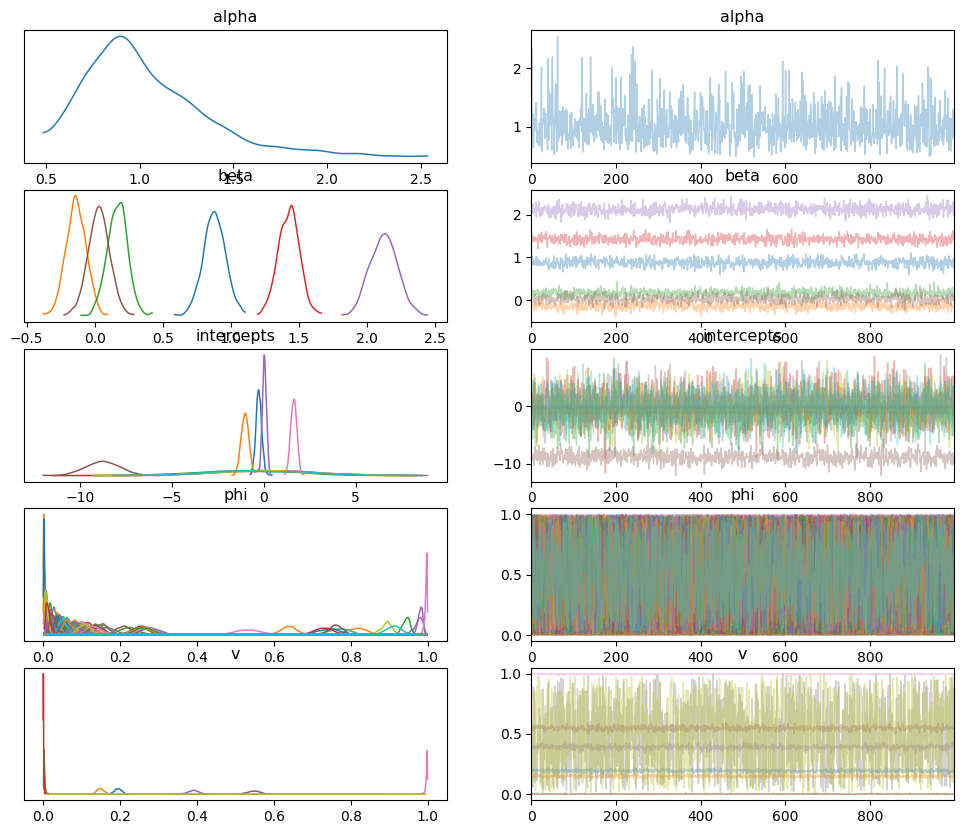

In [53]:
fig = az.plot_trace(az_obj)

## Cluster with no high probability discrete features and some events

In [54]:
importlib.reload(dg)

<module 'data_gen' from '/Users/jim/Library/CloudStorage/OneDrive-SwanseaUniversity/home/code/profile_regression/profile_regression_numpyro/data_gen.py'>

In [55]:
data = dg.gen_data(
    N=2000, 
    K=5,
    D=20,
    R=6,
    n_features_factor=1.0,
    prob_cutoff=0.1,
    empty_cluster=False,
    empty_cluster_with_outcome=True,
    seed=451
)

In [56]:
disc_data = data["dataframe"].loc[:, [k for k in data["dataframe"].keys() if k.startswith("disc_var_")]].to_numpy()
r_data = data["dataframe"].loc[:, [k for k in data["dataframe"].keys() if k.startswith("r_var_")]].to_numpy()

az_obj, loss = pr.fit_profile_regression_model(
    disc_data,
    r_data,
    data["dataframe"]["outcome"].to_numpy(),
    10,
    5000,
    1000,
    alpha=None
)

<timed exec>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


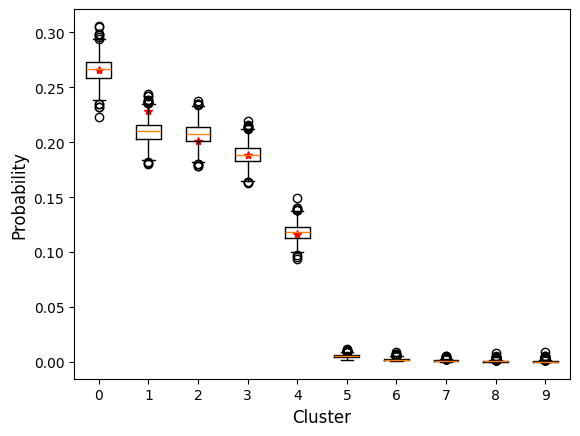

CPU times: user 1.04 s, sys: 30.1 ms, total: 1.07 s
Wall time: 1.65 s


In [57]:
%%time

v_samples = az_obj["posterior"]["v"].to_numpy().squeeze()

weight_mat = np.zeros((v_samples.shape[0], v_samples.shape[-1] + 1))
for i in range(v_samples.shape[0]):
    weight_mat[i, :] = pr.mix_weights(v_samples[i, :])

inds = np.argsort(np.median(weight_mat, axis=0))[::-1]
    
plt.figure()
plt.plot(range(1, len(data["cluster_probs"]) + 1), sorted(data["cluster_probs"])[::-1], "r*")
plt.boxplot(weight_mat[:, inds], labels=range(weight_mat.shape[-1]))
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("no_cluster_w_outcome_probs.png", dpi=300)
plt.show()

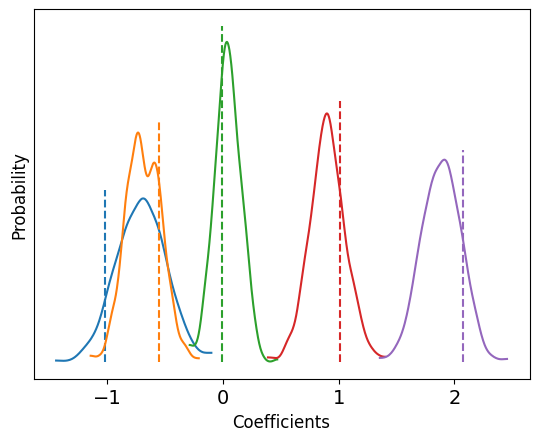

In [58]:
cluster_inds = np.argsort(np.median(weight_mat, axis=0))[::-1][0:5]
coef_inds = []
for i in cluster_inds:
    coef_inds.append([np.mean(az_obj.posterior.sel(intercepts_dim_0=i)["intercepts"].to_numpy()), i])

intercept_inds = np.array(sorted(coef_inds), dtype=int)[:, 1]
    
plt.figure()
for cnt, i in enumerate(intercept_inds):
    fig = az.plot_dist(
        az_obj.posterior.sel(intercepts_dim_0=i)["intercepts"], color="C{}".format(cnt)
    )    
    plt.vlines(sorted(data["intercepts"])[cnt], 0, 1.05 * fig.lines[cnt].get_ydata().max(), color="C{}".format(cnt), linestyle="dashed")

plt.yticks([])
plt.xlabel("Coefficients", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.savefig("no_cluster_w_outcome_coefs.png", dpi=300)
plt.show()

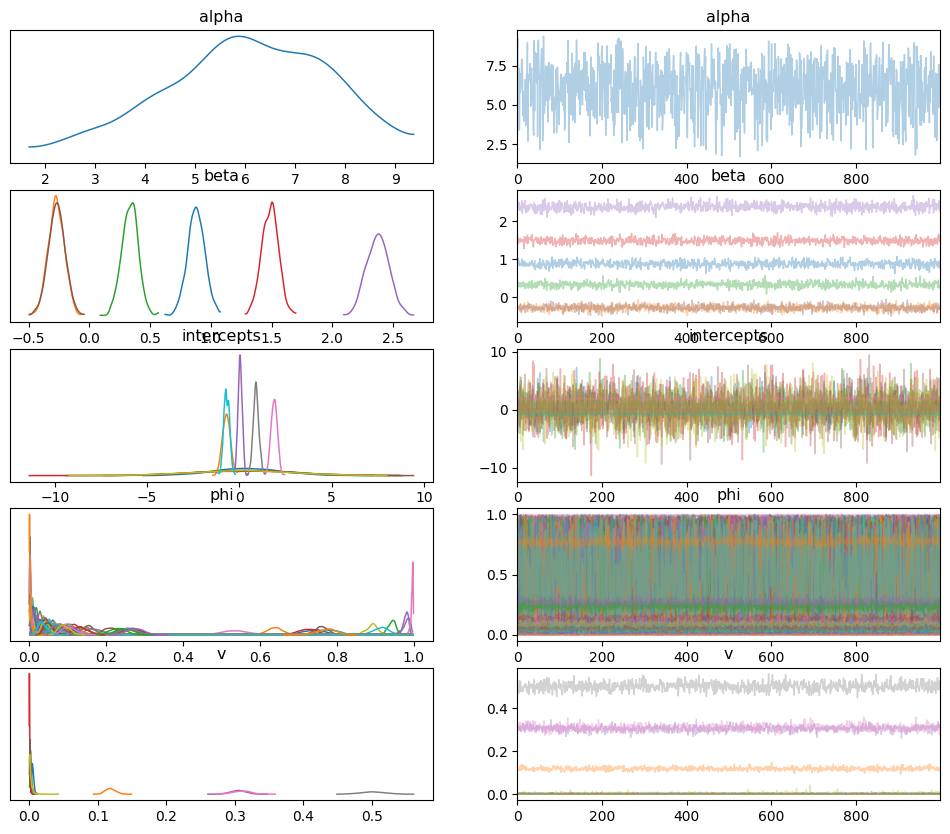

In [59]:
fig = az.plot_trace(az_obj)

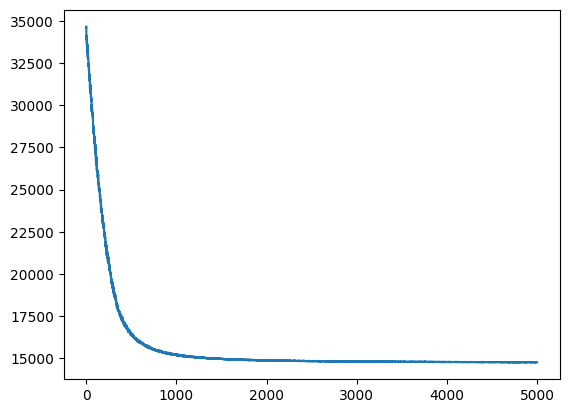

In [60]:
plt.figure()
plt.plot(loss)
plt.show()

# Cross validation with gradient per cluster

In [61]:
importlib.reload(pr)

<module 'models' from '/Users/jim/Library/CloudStorage/OneDrive-SwanseaUniversity/home/code/profile_regression/profile_regression_numpyro/models.py'>

In [91]:
data = dg.gen_data(N=2000, K=4, D=dims, R=6, prob_cutoff=0.1, cluster_gradients=True, seed=16)
disc_data = data["dataframe"].loc[:, [k for k in data["dataframe"].keys() if k.startswith("disc_var_")]]
r_data = data["dataframe"].loc[:, [k for k in data["dataframe"].keys() if k.startswith("r_var_")]]
outcome = data["dataframe"]["outcome"].to_numpy()

In [92]:
data["coefficients"]

array([[-0.05331352,  0.24910377,  0.67222392, -0.55432276],
       [-1.02131474, -0.85582212, -0.0481094 , -2.11823979],
       [ 0.62418673, -1.97469876,  0.93971246,  0.0140904 ],
       [-0.887874  ,  0.41943397, -0.07642427, -1.19930694],
       [ 2.62961668,  1.04217149, -0.10936918,  0.23768659],
       [-1.08009745, -0.89484183, -0.81595784,  0.5991928 ]])

In [93]:
data["coefficients"].mean(axis=-1)

array([ 0.07842285, -1.01087151, -0.09917729, -0.43604281,  0.9500264 ,
       -0.54792608])

In [ ]:
pr.k_fold_ELPD_profile_regression(
    disc_data.to_numpy(),
    r_data.to_numpy(),
    outcome,
    10,
    500,
    1000,
    folds=10,
    parallel=1,
    verbose=True,
    alpha=None,
    cluster_gradients = False
)

In [41]:
pr.k_fold_ELPD_profile_regression(
    disc_data.to_numpy(),
    r_data.to_numpy(),
    outcome,
    10,
    500,
    1000,
    folds=10,
    parallel=1,
    verbose=True,
    alpha=None,
    cluster_gradients = True
)

100%|██████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.23it/s]

ELPD summary:
-------------
Main term: -15627.535156
Bias correction: -2.772670
Folds: 10
Undersampling factor: 1.0


-15630.307825803757

In [94]:
%%time

az_obj, loss = pr.fit_profile_regression_model(
    disc_data.to_numpy(),
    r_data.to_numpy(),
    data["dataframe"]["outcome"].to_numpy(),
    10,
    5000,
    1000,
    alpha=None,
    cluster_gradients=True
)


CPU times: user 9.14 s, sys: 868 ms, total: 10 s
Wall time: 6.57 s


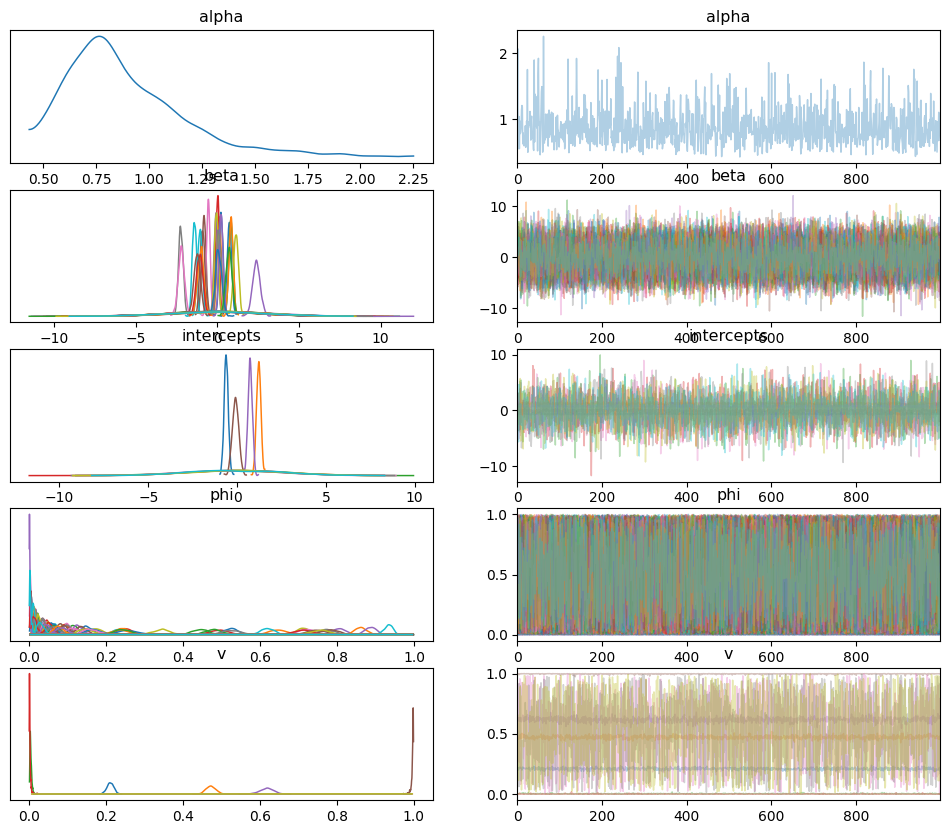

In [95]:
fit = az.plot_trace(az_obj)

<timed exec>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


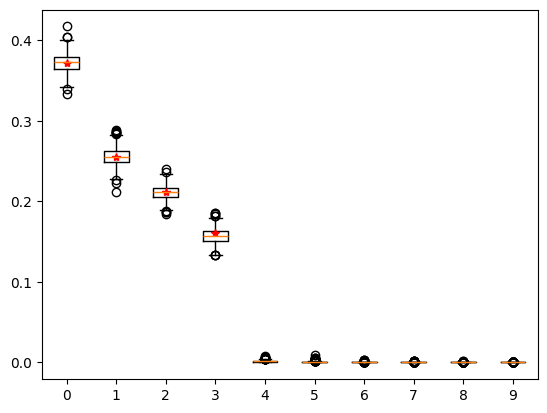

CPU times: user 175 ms, sys: 4.35 ms, total: 179 ms
Wall time: 114 ms


In [97]:
%%time

v_samples = az_obj["posterior"]["v"].to_numpy().squeeze()

weight_mat = np.zeros((v_samples.shape[0], v_samples.shape[-1] + 1))

for i in range(v_samples.shape[0]):
    weight_mat[i, :] = pr.mix_weights(v_samples[i, :])
    
    
inds = np.argsort(np.median(weight_mat, axis=0))[::-1]
    
plt.figure()
bp1 = plt.boxplot(weight_mat[:, inds], labels=range(weight_mat.shape[-1]))
plt.plot(range(1, len(data["cluster_probs"]) + 1), sorted(data["cluster_probs"])[::-1], "r*")
#plt.savefig("SVI_cluster_probs.png", dpi=300)
plt.show()

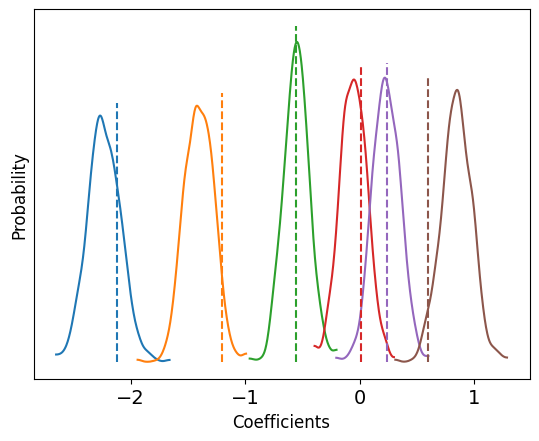

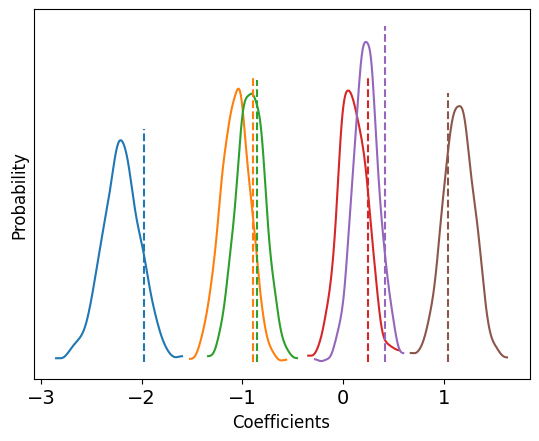

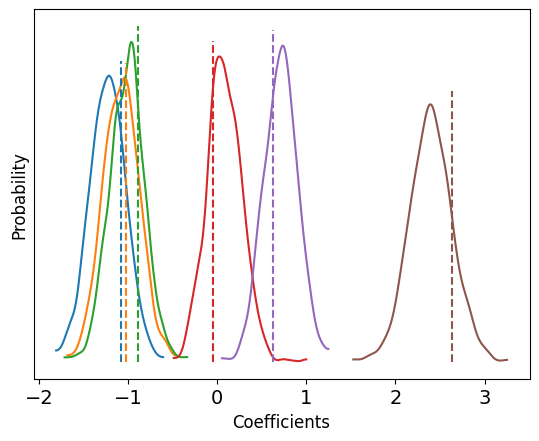

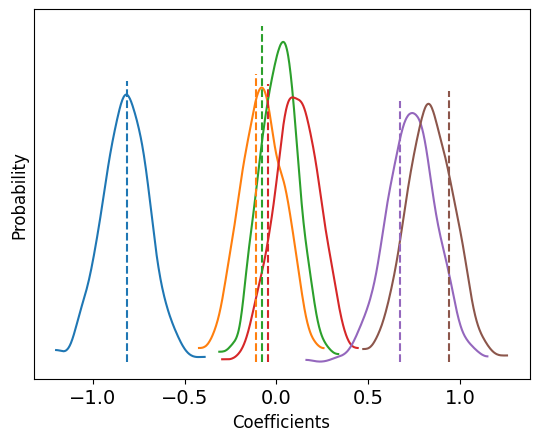

In [98]:
cluster_inds = np.argsort(np.median(weight_mat, axis=0))[::-1][0:4]
coef_inds = []
for i in cluster_inds:
    
    centres = []
    for j in az_obj.posterior["beta_dim_1"]:
        centres.append(np.mean(az_obj.posterior.sel(beta_dim_0=i, beta_dim_1=j)["beta"].to_numpy()))
        
    coef_inds.append([np.min(centres), i])

beta_inds = np.array(sorted(coef_inds), dtype=int)[:, 1]
line_inds = np.argsort(data["coefficients"].min(axis=0))

for cnt, i in enumerate(beta_inds):
    plt.figure()
    for col, j in enumerate(np.argsort(az_obj.posterior.sel(beta_dim_0=i)["beta"].squeeze().mean(axis=0)).to_numpy()): #az_obj.posterior["beta_dim_1"]:
        fig = az.plot_dist(
            az_obj.posterior.sel(beta_dim_0=i, beta_dim_1=j)["beta"], color="C{}".format(col)
        )    
        
    for col, j in enumerate(sorted(data["coefficients"][:, line_inds[cnt]])):
        plt.vlines(j, 0, 1.05 * fig.lines[col].get_ydata().max(), color="C{}".format(col), linestyle="dashed")

    plt.yticks([])
    plt.xlabel("Coefficients", fontsize=12)
    plt.ylabel("Probability", fontsize=12)
    plt.savefig("cluster_gradient_cluster_{}.png".format(cnt))

# Aside: Graphical representation of models

In [ ]:
import os
# NOTE - graphviz is a downloadable file that doesn't require installation. 
os.environ["PATH"] += os.pathsep + 'C:/Users/j.m.rafferty/OneDrive - Swansea University/home/code/Graphviz/bin'

numpyro.render_model(
    model=model,
    model_args = (2, len(disc_data), len(disc_data.keys()), len(r_data.keys()), r_data.to_numpy(), disc_data.to_numpy(), data["dataframe"]["outcome"]),
    render_distributions=True,
    render_params=True
)

# Aside: How to do automatic reparameterisation

In [ ]:
reparam_config = {
    "mu_alpha": numpyro.infer.reparam.LocScaleReparam(0),
    "mu_beta": numpyro.infer.reparam.LocScaleReparam(0),
    "sigma_alpha": numpyro.infer.reparam.LocScaleReparam(0),
    "sigma_beta": numpyro.infer.reparam.LocScaleReparam(0),
    "phi_alpha_beta": numpyro.infer.reparam.LocScaleReparam(0)
}

reparam_pr_model = numpyro.handlers.reparam(
    profile_regression_model, config=reparam_config
)



In [ ]:
kernel = NUTS(reparam_pr_model, target_accept_prob=0.97)
mcmc_reparam = MCMC(
    kernel,
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=1
)
mcmc_reparam.run(
    rng_key,
    K=k,
    N = len(disc_data), 
    D_discrete = len(disc_data.keys()), 
    D_response = len(r_data.keys()),
    X_discrete=disc_data.to_numpy(),
    X_response=r_data.to_numpy(),
    y=data["dataframe"]["outcome"]
) 

In [ ]:
mcmc_reparam.print_summary()